In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from sklearn.metrics import roc_curve
import torch
from torch.autograd import Variable

In [226]:
protected_var = 'sex'
if protected_var == 'sex':
  protected_var_categories = ['Male', 'Female']
elif protected_var == 'race':
  protected_var_categories = ['White', 'Black', 'Asian', 'American-Indian', 'Other']

In [227]:
# Data paths
path = 'data/adult/'
X_name = path + 'X_valid.pkl' # CHANGE TO VAL
y_name = path + 'y_valid.pkl'
z_name = path + protected_var + '_valid.pkl'

In [228]:
# Load data
def load_data(fname):
  data = pd.read_pickle(fname)
  return data.values, Variable(torch.tensor(data.values).float())

X, X_tensor = load_data(X_name)
y, y_tensor = load_data(y_name)
z, z_tensor = load_data(z_name)

In [293]:
# Model paths
path = 'logs/adult/'
alpha_names = []
# alphas = ['0.1', '0.5', '1', '1.5', '2.5', '5', '7.5', '10']
alphas = ['0.1', '1', '10']
for alpha in alphas:
  alpha_names.append(path + protected_var + '-parity-alpha-model/' + 'learning_rate_0.001-num_iters_2500-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_' \
    + alpha + '-model.pth')
  
basic_model_name = path + 'basic-model/' + 'learning_rate_0.001-num_iters_2000-n_h_10--dropout_rate_0.5--model.pth'
odds_model_name = path + protected_var + '-odds-model/' + 'learning_rate_0.001-num_iters_2000-n_h_100-n_h_adv_10-dropout_rate_0.5-alpha_1-model.pth'
parity_model_name = path + protected_var + '-parity-model/' + 'learning_rate_0.001-num_iters_2000-n_h_100-n_h_adv_10-dropout_rate_0.5-alpha_1-model.pth'

In [294]:
# Load models
def load_model(fname):
  model = torch.load(fname)
  model.eval()
  return model

basic_model = load_model(basic_model_name)
odds_model = load_model(odds_model_name)
parity_model = load_model(parity_model_name)
alpha_models = {}
for i, alpha in enumerate(alphas):
  alpha_models[alpha] = load_model(alpha_names[i])

/Users/justinchen/miniconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [295]:
def get_roc(model):
  ypred = model(X_tensor).data.numpy().squeeze()
  curves = []
  for i in range(len(protected_var_categories)):
    curves.append(roc_curve(y[z == i], ypred[z == i]))
  return curves
  
basic_roc = get_roc(basic_model)
odds_roc = get_roc(odds_model)
parity_roc = get_roc(parity_model)
alpha_rocs = {}
for alpha in alpha_models:
  alpha_rocs[alpha] = get_roc(alpha_models[alpha])

In [296]:
colors = ['blue', 'green', 'black'] #cm.nipy_spectral(np.linspace(0, 1, len(protected_var_categories)))
linestyle_dict = {'basic': '-', 'odds': '--', 'parity': ':',
                  'alpha: 0.1': '-', 'alpha: 2.5': '--', 'alpha: 10': ':'}
# linestyles = ['-', '--', ':']
# color_dict = {'basic': 'blue', 'odds': 'red', 'parity': 'green'}

def plot_roc(curves, ax, model_type, xrange=None, yrange=None):
  for i, curve in enumerate(curves):
#     if i >= 3: #plot gets too crowded
#       break
    fpr, tpr, thresholds = curve
    if model_type in linestyle_dict:
      ax.plot(fpr, tpr, label = model_type + ': ' + protected_var_categories[i],
              c=colors[i], linestyle=linestyle_dict[model_type])
    else:
      print(model_type)
      ax.plot(fpr, tpr, label = model_type + ': ' + protected_var_categories[i],
             c=colors[i])
  ax.set_xlabel('False positive rate')
  ax.set_ylabel('True positive rate')
  ax.legend()
  if xrange is not None:
    ax.set_xlim(xrange[0], xrange[1])
  if yrange is not None:
    ax.set_ylim(yrange[0], yrange[1])

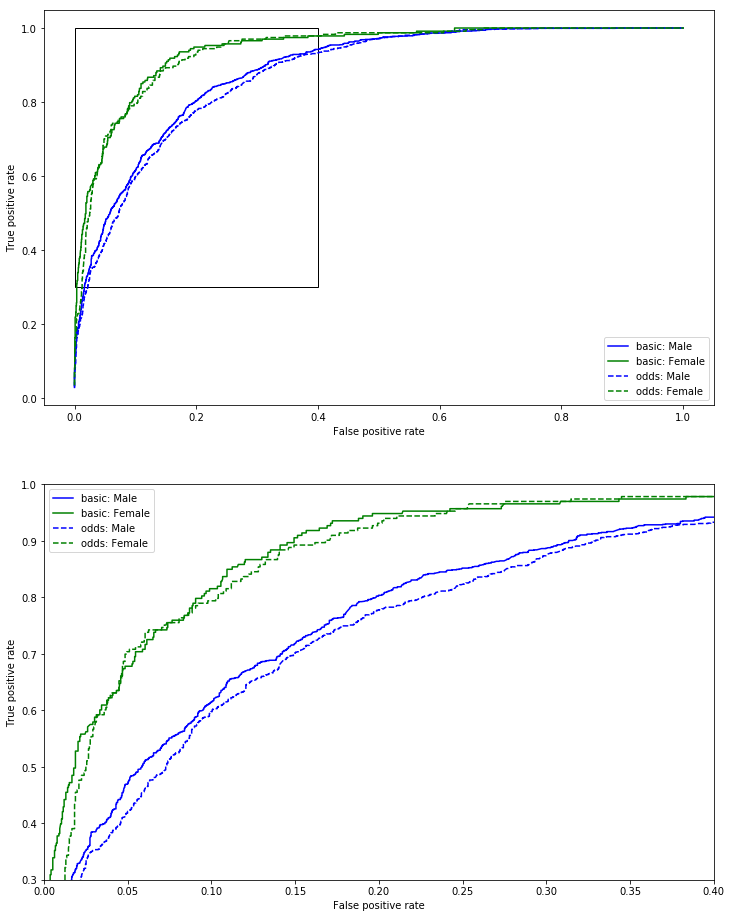

In [297]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
plot_roc(basic_roc, axes[0], 'basic')
plot_roc(odds_roc, axes[0], 'odds')
# plot_roc(parity_roc, axes[0], 'parity')
rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)
# Plot 2 (zoomed)
plot_roc(basic_roc, axes[1], 'basic', xrange=xrange, yrange=yrange)
plot_roc(odds_roc, axes[1], 'odds', xrange=xrange, yrange=yrange)
# plot_roc(parity_roc, axes[1], 'parity', xrange=xrange, yrange=yrange)

alpha: 1
alpha: 1
alpha: 7.5
alpha: 7.5
alpha: 1
alpha: 1
alpha: 7.5
alpha: 7.5


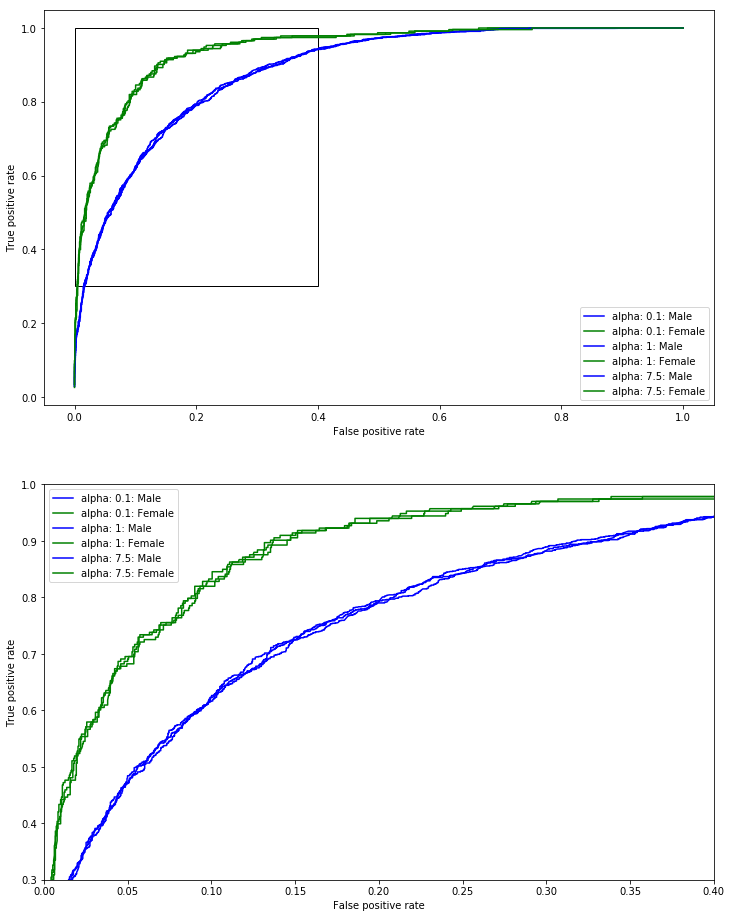

In [298]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
for alpha in alpha_rocs:
  plot_roc(alpha_rocs[alpha], axes[0], 'alpha: ' + alpha)

rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)

# Plot 2 (zoomed)
for alpha in alpha_rocs:
  plot_roc(alpha_rocs[alpha], axes[1], 'alpha: ' + alpha, xrange=xrange, yrange=yrange)

In [285]:
#To do: Make plot of threshold vs acc and tp / fp rates for equality of opportunity